In [1]:
"""
Import the packages needed to simulation of detections and modelling orbital distributions.
"""
%load_ext autoreload
%autoreload 2
import ossssim
from ossssim import models
from ossssim import OSSSSim, DetectFile, ModelFile, ModelOutputFile 
from astropy import units
import numpy
import os


In [2]:
# setup some paths to characterization files and where to store your model outputs.
CHARACTERIZATION_DIR="Surveys"
MODEL_OUTPUT_DIR=os.getenv('HOME')

In [3]:
# I load this Distributions object here so I can select on the Context Senstive Help 
# On the object (click on Distributions) and see what funcitons are defined. 
from ossssim.distributions import Distributions

In [4]:
# We can also create new populations by defining a new class of Parametric or other availalbe model type.  
# A Parametric based orbit model gets a 'cold-classical' H-distribution by default while an Implanted based model gets a 
# H-distribution that is more consistent with the hot-classicals

# NOTE The distributions of orbital elemetns are set by defining the functions with names that match the pattern:
# {element}_distribution  (e.g. a_distribution, e_distribution, M_distribution where the value of element is one of
# [a, e, inc, node, peri, M, H, peri, phi]

# NOTE: When defining a distribution we call the distributions attached to the model (e.g. self.distributions.FUNCTION_NAME )
# this is to ensure that all our distributions are seeded with a common random number and we can thuse re-produce a model if 
# we know the seed value.

class Hot(models.Implanted):
    """
    Class used to create and store the objects generated and passed by the GiMeObj module into the main Driver.py
    module that executes the survey simulator code.
    """
    def __init__(self, q_min=36*units.au, q_max=40*units.au, q_centre=38*units.au,
                 q_width=1*units.au, a_max=100*units.au, a_beta=-5/2, model_band='r', 
                 size=100000, **kwargs):
        """Build a Hot model orbital element distribution based on the peri-centre distribution 
        and declining 'a' distributions as a^beta power
                    
        """
        super().__init__(size=size, H_max=8.5, model_band=model_band, **kwargs)
        self.q_min = q_min
        self.q_max = q_max
        self.q_centre = q_centre
        self.q_width = q_width
        self.a_max = a_max
        self.a_beta = a_beta

    @property
    def q_distribution(self):
        """
        A Normal or Gaussian distribution where we clip values above max and below min to remove
        the long tails of the Normal disrtibution.
        """
        return self.distributions.truncated_normal(mu=self.q_centre.to('au').value, 
                                                   maximum=self.q_max.to('au').value, 
                                                   minimum=self.q_min.to('au').value, 
                                                   sigma=self.q_width.to('au').value) * units.au

    @property
    def q(self):
        if self._q is None:
            self._q = self.q_distribution
        return self._q

    @property
    def a_distribution(self):
        """
        Limited to be larger than 'q' but dropping as a to the power -5/2
        """
        # based on functions described in Distributions.

        # we define our function be go between the minimum value of q and maximum value of a
        fp = numpy.linspace(self.q_min.to('au').value, 
                            self.a_max.to('au').value, 
                            num=1000)
        xp = (fp/self.q_min.to('au').value)**self.a_beta
        xp = xp.cumsum() / xp.sum()  # Normalizes the cdf
        
        # interpolator = self.rnd_gen.uniform(xp[0], xp[-1], self.size)
        # a = numpy.interp(interpolator, xp, fp) * au
            
        # we don't what a fully uniform distribution of 'xp' (likelihood of a given a value) 
        # as we have the additional constraint that a > q so we need to eliminate the 'xp' 
        # values that would return fp < q 
        xp_min = numpy.interp(self.q.to('au').value,
                              fp,
                              xp)
        # Generates an array (of a size given in our instance initialization) of uniformly distributed random values
        # ranging from the minimum value of of our normalized cdf that provides a>q and the maximum value of xo.
        interpolator = self.distributions.rnd_gen.uniform(xp_min, xp[-1], self.size)

        # Calls the interpolation function to generate a randomized array, corresponding to the probability
        # density, by interpolating between the given points.
        return numpy.interp(interpolator, xp, fp) * units.au
    
    @property
    def e_distribution(self):
        """
        Eccentricity axis distribution for a narrow ring
        """
        a = self.a 
        q = self._q
        e = 1 - q/a
        return 1 - self.q/self.a

    @property
    def inc_distribution(self):
        """
        Inclination distribution for a narrow ring
        """
        # truncated_sin_normal expects to get values in radians. 
        return self.distributions.truncated_sin_normal(0.0, 9.0/57.3, 0.0, 45/57.3) * units.radian
        

In [5]:
h = Hot(size=1000000)

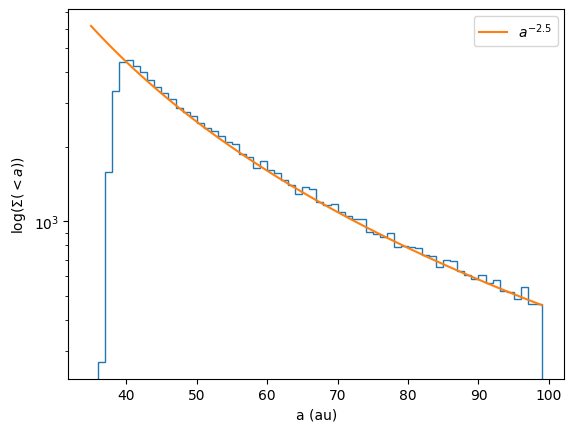

In [6]:
# confirm that the 'a' distribution looks like what we want.
hot = Hot(size=100000)
from matplotlib import pyplot  as plt
n = plt.hist(hot.a, histtype='step', bins=numpy.arange(35,100,1)*units.au)
plt.yscale('log')
plt.xlabel('a (au)')
plt.ylabel('$\log(\Sigma(<a))$')
# expected function, normalized to match the histogram bins from the model 
x =  numpy.arange(35,100,1 )*units.au
y = (x/40)**(hot.a_beta)*n[0][4]
exp = f'{hot.a_beta}'
plt.plot(x,y, label='$a^{'+exp+'}$')
plt.legend()

10000


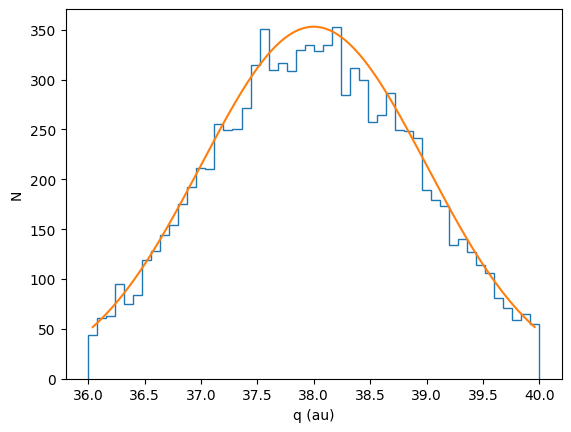

In [7]:
# confirm that the 'q' distribution looks like what we want.
hot = Hot(size=10000)
print(hot.size)
import scipy
from matplotlib import pyplot  as plt
n = plt.hist(hot.q, histtype='step', bins=50)
plt.xlabel('q (au)')
plt.ylabel('N')
# expected function, normalized to match the histogram bins from the model 
x =  numpy.linspace((n[1][0]+n[1][1])/2, (n[1][-1]+n[1][-2])/2, 1000) * units.au
n = (numpy.exp(-(x - hot.q_centre) ** 2 / (2 * hot.q_width ** 2))) * numpy.array(n[0]).max()
plt.plot(x, n)

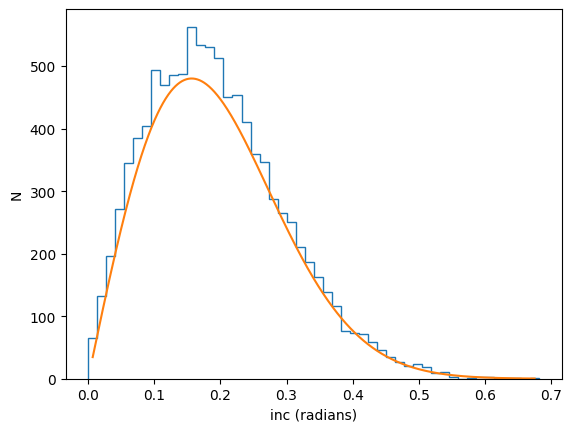

In [8]:
# confirm that the 'inc' distribution looks like what we want.
import scipy
from matplotlib import pyplot  as plt
n = plt.hist(hot.inc, histtype='step', bins=50)
plt.xlabel('inc (radians)')
plt.ylabel('N')
# expected function, normalized to match the histogram bins from the model 
x =  numpy.linspace((n[1][0]+n[1][1])/2, (n[1][-1]+n[1][-2])/2, 1000) * units.radian
n = numpy.sin(x)*(numpy.exp(-x ** 2 / (2 * (9/57.3*units.radian)** 2))) * (numpy.array(n[0])/numpy.sin(n[1][1:])).max()
plt.plot(x, n)

In [9]:
# to determine if an object was detectable we use an OSSSSim object, initializing it with the name of directory holding the 
# survey characterization of interest.
ssim = OSSSSim(characterization_directory=os.path.join(CHARACTERIZATION_DIR,'CFEPS'))

In [10]:
# let's create a model that is 50% twotinos and 50% 'Ring'
from numpy import random
import sys
n_detections = n_iterations = n_tracked = 0

def delete_if_file_exists(filename):
    import os
    if os.access(filename, os.F_OK):
        os.remove(filename)

model_filename = os.path.join(MODEL_OUTPUT_DIR,'example_model.txt')
detect_filename = os.path.join(MODEL_OUTPUT_DIR, 'example_detect.txt')

# Create some objects to store our model and our detections.
# First we delete any existing files with these names as all writes are appends.
for filename in [model_filename, detect_filename]:
    delete_if_file_exists(filename)
    
model_save_file=ModelOutputFile(filename=model_filename)
detect_save_file=DetectFile(filename=detect_filename)

model = Hot(size=10000)

total_iterations = 10000

while n_iterations < total_iterations:
    n_iterations += 1
    row = next(model)
    sys.stdout.write(f"Iteration {n_iterations}\r")
    model_save_file.write_row(row)
    result = ssim.simulate(row, 
                           epoch=model.epoch, 
                           colors=model.colors, 
                           seed=model.seed, 
                           model_band=model.model_band)
    if result['flag'] > 0:
        n_detections += 1
    detect_save_file.write_row(result)

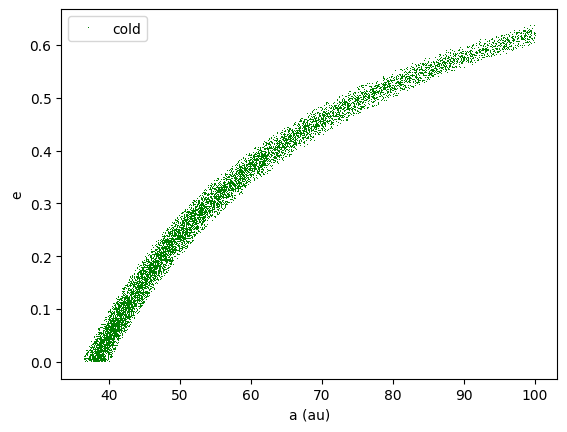

In [11]:
# some diagnostic plots
import matplotlib as mpl
from matplotlib import pyplot
# This installation has no fonts, if working on a local device you might set your font here.
mpl.rcParams['font.family'] = []
mpl.rcParams['font.serif'] = []
pyplot.plot(model_save_file.table['a'], model_save_file.table['e'], ',g', label='cold')
pyplot.ylabel('e')
pyplot.xlabel('a (au)')
pyplot.legend()

findfont: Font family [] not found. Falling back to DejaVu Sans.


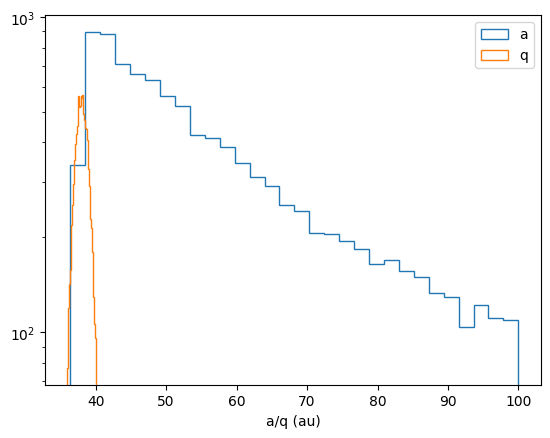

In [13]:
a = numpy.array(model_save_file.table['a'])
q = numpy.array(model_save_file.table['q'])
pyplot.hist(a, bins=30, histtype='step', label='a')
pyplot.hist(q, bins=30, histtype='step', label='q')
# pyplot.ylabel('q (au)')
pyplot.xlabel('a/q (au)')
pyplot.yscale('log')
pyplot.legend()

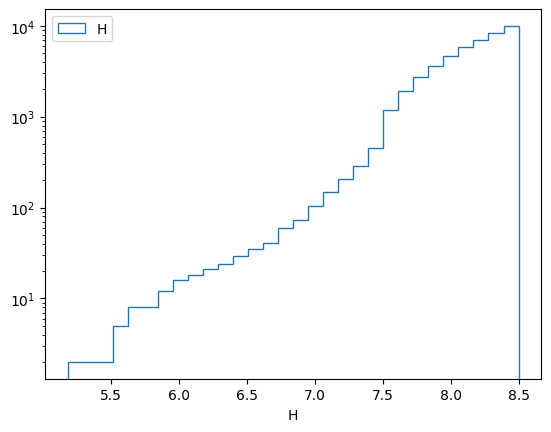

In [14]:
H = numpy.array(model_save_file.table['H'])
pyplot.hist(H, cumulative=True, bins=30, histtype='step', label='H')
# pyplot.ylabel('q (au)')
pyplot.xlabel('H')
pyplot.yscale('log')
pyplot.legend()

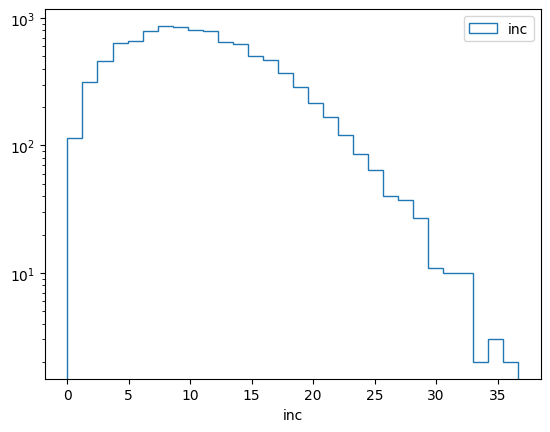

In [15]:
inc = numpy.array(model_save_file.table['inc'])
pyplot.hist(inc, cumulative=False, bins=30, histtype='step', label='inc')
# pyplot.ylabel('q (au)')
pyplot.xlabel('inc')
pyplot.yscale('log')
pyplot.legend()

/opt/SSim/python/ossssim/plotter.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.ax1.set_xticklabels(x_tick_labels, color='b', alpha=0.6)


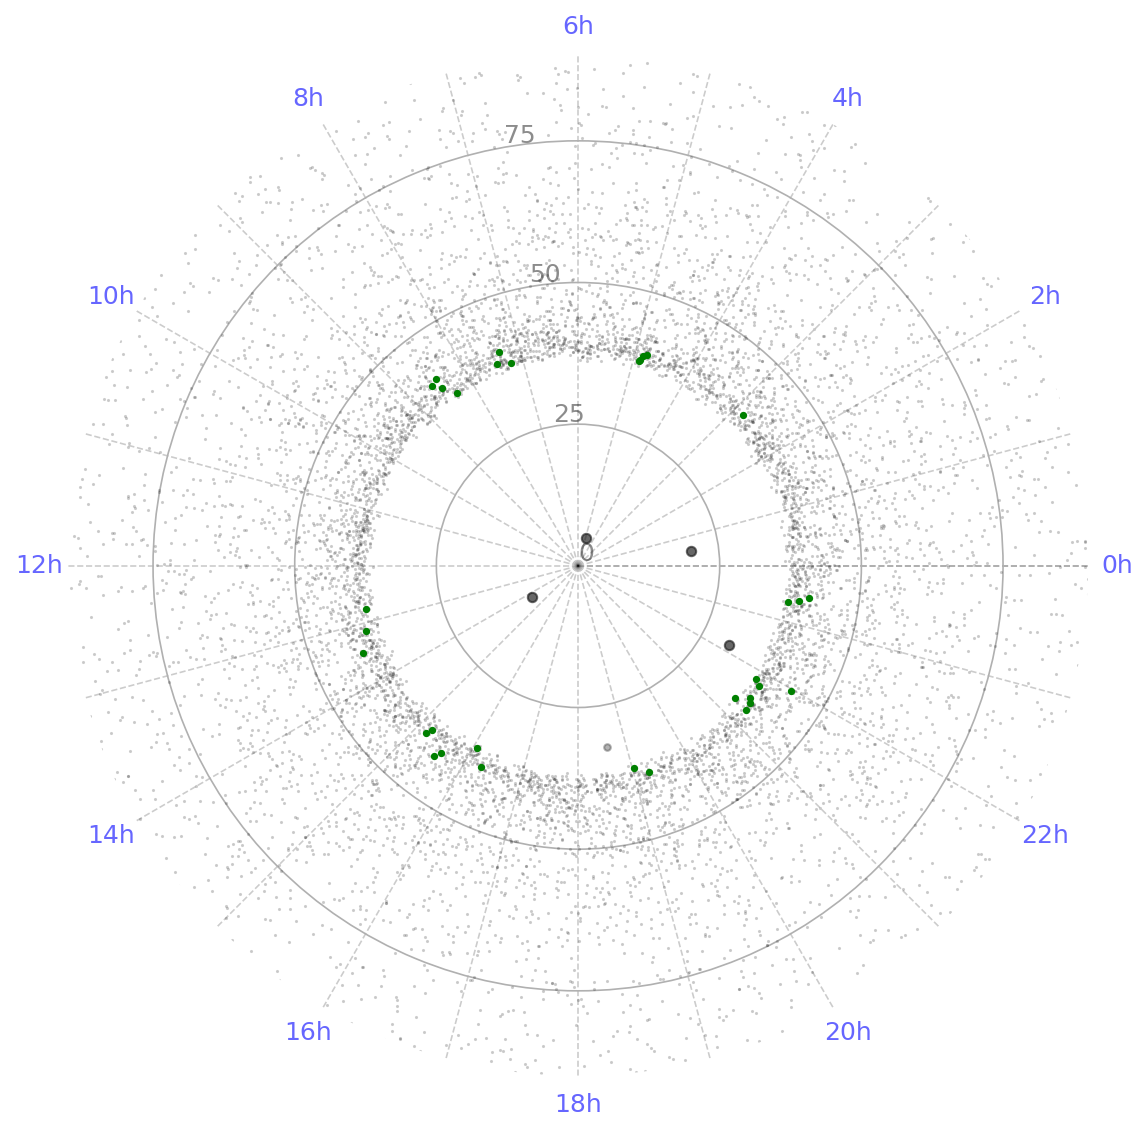

In [16]:
import matplotlib as mpl
from ossssim import plotter
# This installation has no fonts, if working on a local device you might set your font here.
mpl.rcParams['font.family'] = []
mpl.rcParams['font.serif'] = []

plot = plotter.RosePlot(epoch=model_save_file.epoch)
plot.add_model(model_save_file, ms=1, mc='k', alpha=0.2)
plot.add_model(detect_save_file, ms=5, mc='g')
plot.add_planets()
plot.show()
